In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

In [2]:
df1 = pd.read_csv('Bengaluru_House_Data.csv')
df1.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [3]:
df1.shape

(13320, 9)

In [4]:
df1.groupby('area_type')['area_type'].agg('count')

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

- Removing the columns that are not required 
- Generally taking advice from the domain expert in this case the real estate consultant to remove some columns which are not relevant for our model

In [5]:
df2 = df1.drop(['area_type','availability','balcony','society'],axis='columns')
df2.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


In [6]:
df2.shape

(13320, 5)

### 2. Data Cleaning and Exploring

- First starts with handling the null values
- Next is to standardizing the values in each columns
- Removing Outliers
- Dimenional Reduction - if there are many features

#### 2.1 Handling the null values

In [7]:
df2.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

- Since the number of missing values are negligible, we can safely remove the rows (but again this is subjective)
- We can also fill the missing values if the number of missing values are significant with mean median, mode or using some machine learning algorithm

In [8]:
df3 = df2.dropna()
df3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [9]:
df3.shape

(13246, 5)

#### 2.2 Standardising the values in the column

- For example here in case of size the bedroom size is not standard

In [10]:
df3['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

- Here we can see the bedrooms are not formatted in a proper standard
- hene we will extract the usefull information i.e. the size of the bedroom as integer and make a new column

In [11]:
df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))
df3.head()

/home/kavyajeet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


Now lets inspect the new bhk column and look for anomalies

In [12]:
df3['bhk'].unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18])

In [13]:
df3[df3['bhk']>20]

,location,size,total_sqft,bath,price,bhk
1718,2Electronic City Phase II,27 BHK,8000,27.0,230.0,27
4684,Munnekollal,43 Bedroom,2400,40.0,660.0,43


Here we can see some bhks are more than 20 and one of the record with 43 bhk is having very less total sqft area. Looks like an outlier. This we will remove it while removing the outliers 

Inspecting the values total sqft area column

In [14]:
df3['total_sqft'].unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

Some values are are not a single number but a range in string format. We need to convert these values to a single value. Here we can use average value

- First inspect the string value

In [15]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True


df3[~df3['total_sqft'].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


- These are the values that are stored as string and given as range
- Also the values are not standard
- Considering values only in the form of "2000-3000" and converting them to float using average method
- Ignoring/dropping rest of the values in other format like 34.46Sq. Meter, 4125Perch etc

In [16]:
def avg_sqft(x):
    tokens = x.split('-')
    if len(tokens)==2:
        return (float(tokens[0])+float(tokens[1]))/2
    
    try:
        return float(x)
    except:
        return None

In [17]:
df4 = df3.copy() ## creating a deep copy 
df4['total_sqft'] = df3['total_sqft'].apply(avg_sqft)
df4.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2


#### 2.3 Feature Engineering and Dimenional Reduction

- Creating a new feature to detect outliers

In [18]:
df5 = df4.copy()
df5['price_per_sqft'] = df4['price']*100000/df4['total_sqft']
df5.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


**Inpection the location column**
- the string column is usually converted to one hot encoding feature for prediction
- If there are many number of values in the column the number of feature will be very large and cause high dimentionality problem
- This can be tackled using many techniques, one of the simplest one is to tag the very less occuring values as one class ("Other")

In [19]:
## cleaining the location column before analysing
df5.location = df5.location.apply(lambda x: x.strip())

In [20]:
len(df5.location.unique())

1293

In [21]:
location_counts = df5.location.value_counts()
location_counts

Whitefield                                535
Sarjapur  Road                            392
Electronic City                           304
Kanakpura Road                            266
Thanisandra                               236
Yelahanka                                 210
Uttarahalli                               186
Hebbal                                    176
Marathahalli                              175
Raja Rajeshwari Nagar                     171
Bannerghatta Road                         152
Hennur Road                               150
7th Phase JP Nagar                        149
Haralur Road                              141
Electronic City Phase II                  131
Rajaji Nagar                              106
Chandapura                                 98
Bellandur                                  96
KR Puram                                   88
Hoodi                                      88
Electronics City Phase 1                   87
Yeshwanthpur                      

Here we can see many columns are occuring very less frequently. Hence we can reduce the dimension of the one hot encoded column by converting these less frequently occuring values as into one group.

To do this we can keep a threshold saying that less than this threshold will be classified as other location

In [22]:
location_less_than_10 = location_counts[location_counts <= 10]
print('Total location which are occuring less than 10:',len(location_less_than_10))
location_less_than_10.index

Total location which are occuring less than 10: 1052


Index(['Nagappa Reddy Layout', 'Sector 1 HSR Layout', 'Naganathapura',
       'Gunjur Palya', 'Sadashiva Nagar', '1st Block Koramangala',
       'BTM 1st Stage', 'Ganga Nagar', 'Nagadevanahalli', 'Kalkere',
       ...
       'Medaralli', 'NR Colony', 'Sadahalli', 'Kanakapura Main Road',
       'K G Colony', 'Mailasandra', 'Viviani Road',
       '3rd Stage Raja Rajeshwari Nagar', 'Nirman Layout', 'AGB Layout'],
      dtype='object', length=1052)

These are the locations which are occuring less than 10 times

In [23]:
df5.location = df5.location.apply(lambda x: "other" if x in location_less_than_10 else x)
df5.head(10)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
5,Whitefield,2 BHK,1170.0,2.0,38.00,2,3247.863248
6,Old Airport Road,4 BHK,2732.0,4.0,204.00,4,7467.057101
7,Rajaji Nagar,4 BHK,3300.0,4.0,600.00,4,18181.818182
8,Marathahalli,3 BHK,1310.0,3.0,63.25,3,4828.244275
9,other,6 Bedroom,1020.0,6.0,370.00,6,36274.509804


In [24]:
len(df5.location.unique())

242

#### 2.4 Removing Outliers

- there can be many outlier detection techniques
- One can using standard deviation
- Other can be using domain knowledge - like for example **one bedroom is typically not less than 300.**
- Here we will inspect each column for outlier detection

In [25]:
df5[df5['total_sqft']/df5['bhk']<300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


In [26]:
df5.shape

(13246, 7)

In [27]:
df6 = df5[~(df5['total_sqft']/df5['bhk']<300)]
df6.shape

(12502, 7)

In [28]:
## insepcting the price per sqft

df6.price_per_sqft.describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

- Minimum price per sqft is 267 which is unlikely to find in bengaluru city
- Also maximum value is 176470 which is a very high value
- We will look for outliers in this column and remove the very less frequently occuring values using standard deviation

In [29]:
def remove_sqft_outlier(df):
    '''
    This function removes outliers which are outside of 1 std deviation from mean
    The removal is done location wise, because the mean for different location is different
    and returns a dataframe without those outliers
    '''
    df_out = pd.DataFrame()
    for location, sdf in df.groupby('location'):
        mean = np.mean(sdf.price_per_sqft)
        std = np.std(sdf.price_per_sqft)
        sdf = sdf.loc[(sdf['price_per_sqft']>= (mean-std)) & (sdf['price_per_sqft']<= (mean+std))]
        df_out = pd.concat([df_out,sdf],ignore_index=True)

    return df_out

df7 = remove_sqft_outlier(df6)
df7.shape

(10241, 7)

In [30]:
help(remove_sqft_outlier)

Help on function remove_sqft_outlier in module __main__:

remove_sqft_outlier(df)
    This function removes outliers which are outside of 1 std deviation from mean
    The removal is done location wise, because the mean for different location is different
    and returns a dataframe without those outliers



One more point - 
- In some cases it is observed that 1BHK in the same area is costlier than 2BHK or more. This can be due to several reasons but assuming the same price per sqft in the same location. we will remove those data points which are lesser than the mean value of the preceding BHK value. 

- Like for example while removing the outliers from 2BHK group for a particular location, we will check for values which are lesser than the mean value of all 1 BHK in that area and remove them.

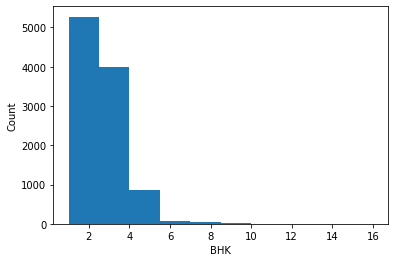

In [31]:
plt.hist(df7.bhk)
plt.xlabel('BHK')
plt.ylabel('Count')
plt.show()

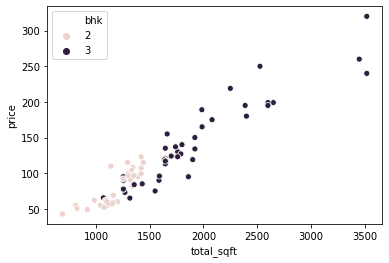

In [32]:
sns.scatterplot(x='total_sqft',y='price',data=df7.loc[(df7['bhk']<4) & (df7['location']=='Hebbal')], hue='bhk')
plt.show()

- Here we can see that some 3 bhk properties are having lesser values than 2bhk values in the same area. 
- Hence we will remove some of these outliers

In [33]:
def remove_outliers_2(df):
    
    '''
    Removes the outliers - removes N bhk properties that are having lesser price per sqft 
    than mean value of N-1 bhk properties.
    And returns a dataframe
    '''
    exclude_indices = []
    for location, data in df.groupby('location'):
        
        bhk_stats = {}
        for bhk, bhk_data in data.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean':np.mean(bhk_data.price_per_sqft),
                'std':np.std(bhk_data.price_per_sqft),
                'count': bhk_data.shape[0]
            }

        for bhk, bhk_data in data.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count'] > 5:
                exclude_indices.extend(bhk_data[bhk_data['price_per_sqft']< (stats['mean'])].index)

    return df.drop(exclude_indices,axis=0)

df8 = remove_outliers_2(df7)
df8.shape

(7329, 7)

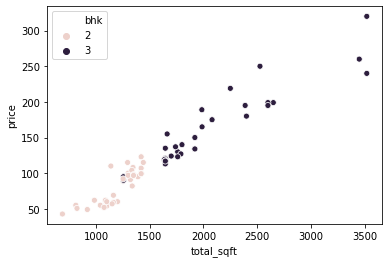

In [34]:
sns.scatterplot(x='total_sqft',y='price',data=df8.loc[(df8['bhk']<4) & (df8['location']=='Hebbal')], hue='bhk')
plt.show()

Now we can see that the overlapping outliers are removed. There are some but it is very hard to remove values in the interface.

Now lets explore the bathroom feature

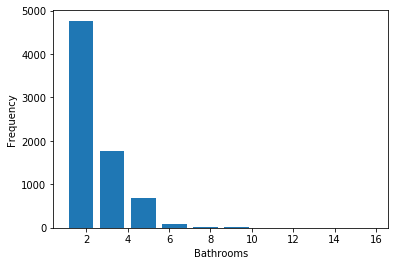

In [35]:
plt.hist(df8['bath'],rwidth=0.8)
plt.xlabel('Bathrooms')
plt.ylabel('Frequency')
plt.show()

Mostly the value of bathroom are in less than 6. 

In [36]:
df8['bath'].unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

In [37]:
df8[df8['bath']>10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
5277,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
8486,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
8575,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
9308,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
9639,other,13 BHK,5425.0,13.0,275.0,13,5069.124424


- Here we can see the number of bathrooms are even more than 10.
- We can see that as the number of bedrooms increases the bathroom also increases.
- But here it is unlikely to have bathroom which are say more than the number of bedrooms. In extreme cases number of bathroom cannot be more than 2 + number of bedrooms - which is suggestion taken from the domain expert.
- hence we will remove the data points which satisfy this above condition

In [38]:
more_bath = df8[df8['bath']>=df8['bhk']+2]
more_bath.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
36,2nd Stage Nagarbhavi,6 Bedroom,3000.0,8.0,451.0,6,15033.333333
37,2nd Stage Nagarbhavi,6 Bedroom,2400.0,8.0,450.0,6,18750.000000
530,Arekere,4 BHK,2710.0,6.0,142.0,4,5239.852399
580,BTM 2nd Stage,3 Bedroom,1260.0,5.0,185.0,3,14682.539683
813,Bannerghatta,4 BHK,3012.0,6.0,250.0,4,8300.132802


In [39]:
df9 = df8[(df8['bath']<df8['bhk']+2)]
df9.shape

(7251, 7)

Summary for this section 
- Removed null values
- Standarsized the bhk column
- Reduction of dimenality of the categorical location column by classifying the less frequently occuring location as "others". Here the threshold used was frequency less than or equal to 10. 
- Removal of outliers 
    - first removed outliers in bhk column which are having less than 300 sqft per bhk 
    - then removed data points which are not within 1 standard deviation of the mean of price per sqft per location
    - removed data points with N bhks having price per sqft lesser than the mean price per sqft of N-1 bhk for the same location
    - then inspected the number of bathrooms and removed outliers which were having bathrooms more than or equal to 2+number of bhks for the same property

### 3. Modelling

- We will remove the unnecessary features that are not required for modelling
- Which are price per sqft which was used for outlier detection
- size feature as it was already cleaned and stored in a new column

In [40]:
df10 = df9.drop(['size','price_per_sqft'],axis=1)
df10.head()

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3
3,1st Block Jayanagar,1200.0,2.0,130.0,3
4,1st Block Jayanagar,1235.0,2.0,148.0,2


One hot encoding for the location column since it is in string 

In [41]:
one_hot_encoded = pd.get_dummies(df10.location)
one_hot_encoded.head()

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [79]:
## to avoid a dummy variable trap, we need to drop one column
## we will drop the other column
## so if the location is all zeros it means it is others

df11 = pd.concat([df10,one_hot_encoded.drop('other',axis='columns')],axis='columns')
df11.head()

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,235.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,1200.0,2.0,130.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,1235.0,2.0,148.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


 Now location column is not needed anymore we remove it.

In [80]:
df12 = df11.drop('location',axis='columns')
df12.head()

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,235.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,130.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,148.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now are data frame is ready. We will proceed with the modelling. 
- creating independent and dependent variables
- Normalize the train variables and transform the test values based on this
- Divide the data set into training and test dataset
- 

In [81]:
X = df12.drop('price',axis='columns')
X.head()

,total_sqft,bath,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
Y = df12['price']
Y.head()

0    428.0
1    194.0
2    235.0
3    130.0
4    148.0
Name: price, dtype: float64

In [83]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=10)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(5800, 244) (1451, 244) (5800,) (1451,)


Starting with a very simple model - Linear regression

- The score method returns the goodness of fit i.e. R2 coefficient. 
- In statistics, the coefficient of determination, denoted R2 or r2 and pronounced **"R squared", is the proportion of the variance in the dependent variable that is predictable from the independent variable(s)**.
- 0% indicates that the model explains none of the variability of the response data around its mean. 100% indicates that the model explains all the variability of the response data around its mean

In [84]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, Y_train)
lr.score(X_test,Y_test)

0.845227769787428

Here around 84% of the variance of the dependent variable i.e. the price is explained by the independent variable.


Now lets try KFold cross-validation test on the dataset. 
- ShuffleSplit = this will create random splits and seperate the data into training and test dataset
- then cross_val_score will train the model on given method and test it on the test set, and give a score based on it

In [85]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
cross_val_score(LinearRegression(), X,Y, cv=cv)

array([0.82430186, 0.77166234, 0.85089567, 0.80837764, 0.83653286])

**Hyperparameter tuning using Grid Search CV**

- Here we will test different models with different parameters to check which model is best for out data
- Based on that we will choose the best model which gives highest R2 value.

In [86]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor


def return_best_model_using_grid_search_cv(x,y):
    algos = {
        'linear_regression':{
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso':{
            'model': Lasso(),
            'params':{
                'alpha':[1,2],
                'selection':['random','cyclic']
            }
        },
        'decision_tree':{
            'model':DecisionTreeRegressor(),
            'params':{
                'criterion': ['mse','friedman_mse'],
                'splitter':['best','random']
            }
        }    
    }

    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs = GridSearchCV(config['model'],config['params'], cv=cv, return_train_score=False)
        gs.fit(x,y)
        scores.append({
            'model': algo_name,
            'best_score':gs.best_score_,
            'best_params':gs.best_params_
        })

    return pd.DataFrame(scores, columns=['model','best_params','best_score'])

In [87]:
%%time
return_best_model_using_grid_search_cv(X,Y)

CPU times: user 6.96 s, sys: 845 ms, total: 7.8 s
Wall time: 5.62 s


,model,best_params,best_score
0,linear_regression,{'normalize': False},0.818354
1,lasso,"{'alpha': 1, 'selection': 'cyclic'}",0.687429
2,decision_tree,"{'criterion': 'mse', 'splitter': 'best'}",0.728004


- We can conclude that linear model is best fit for this dataset
- We will use the previously trained model for prediction

In [95]:
list(X.columns).index('1st Block Jayanagar')

3

In [98]:
def predict(location,total_sqft, bath, bhk):
    
    x_input = np.zeros(len(X.columns))
    loc_index = list(X.columns).index(location)
    x_input[0] = total_sqft
    x_input[1] = bath
    x_input[2] = bhk
    x_input[loc_index] = 1
    
    return lr.predict(x_input.reshape(1,-1))

In [99]:
predict('1st Phase JP Nagar',1000,2,2)

array([83.49904677])

In [100]:
predict('1st Phase JP Nagar',1000,3,3)

array([86.80519395])

In [101]:
predict('Indira Nagar',1000,2,2)

array([181.27815484])

In [102]:
predict('Indira Nagar',1000,2,3)

array([179.50527708])

**Observation**

- for the same area, 2bhk are costlier than 3bhk which is because per bhk the space is more for 2bhk, more spacious hence more costlier

### Export the model to a pickle file

- Exporting the file into a pickle file which will be used by our python flask server

In [104]:
import pickle
with open('house_price_prediction_model.pickle','wb') as file:
    pickle.dump(lr,file)

Exporting the columns also into as json file because when loading the model we need the the column names to mantain the same structure of the dataframe which was used to build the model. 

In [107]:
import json
columns = {
    'data_columns': [x.lower() for x in X.columns]
}
with open('columns.json','w') as f:
    f.write(json.dumps(columns))

[What is the difference between json.loads() and json.dumps()?](https://www.educative.io/edpresso/what-is-the-difference-between-jsonloads-and-jsondumps)